# Model oceniający zdolność kredytową aplikantów o pożyczkę

Do analizy wybrałem zbiór opisujący osoby aplikujące o kredyt, pobrany z https://www.kaggle.com/datasets/bhavikjikadara/loan-status-prediction. Celem jest stworzenie modelu, który na podstawie zebranych danych będzie w stanie określić, czy dana osoba powinna otrzymać pożyczkę, czy nie.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Wczytujemy plik z bazą danych:

In [2]:
df = pd.read_csv("loan_data.csv")

In [3]:
df.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
1,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
2,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
3,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y
4,LP001013,Male,Yes,0,Not Graduate,No,2333,1516.0,95.0,360.0,1.0,Urban,Y


Opis kolumn:
- Loan_ID: Unikalny numer identyfikacyjny,
- Gender: Płeć aplikanta,
- Married: Stan cywilny aplikanta,
- Dependents: Liczba osób zależnych od osoby składającej wniosek,
- Education: Poziom wykształcenia,
- Self_Employed: Czy aplikant jest samozatrudniony,
- ApplicantIncome: Przychód aplikanta,
- CoapplicantIncome: Przychód koaplikanta,
- LoanAmount: Wielkość pożyczki w tysiącach,
- Loan_Amount_Term: Długość pożyczki w miesiącach,
- Credit_History: Zgodność historii kredytowej z wytycznymi,
- Property_Area: Czy aplikant mieszka w rejonie miejskim, podmiejskim, czy wiejskim,
- Loan_Status: Status pożyczki (zaakceptowana lub nie).

Kolumna "Loan_ID" nie będzie nam potrzebna do analizy, może zostać pominięta.

In [4]:
df = df.drop(["Loan_ID"], axis=1)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 381 entries, 0 to 380
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Gender             376 non-null    object 
 1   Married            381 non-null    object 
 2   Dependents         373 non-null    object 
 3   Education          381 non-null    object 
 4   Self_Employed      360 non-null    object 
 5   ApplicantIncome    381 non-null    int64  
 6   CoapplicantIncome  381 non-null    float64
 7   LoanAmount         381 non-null    float64
 8   Loan_Amount_Term   370 non-null    float64
 9   Credit_History     351 non-null    float64
 10  Property_Area      381 non-null    object 
 11  Loan_Status        381 non-null    object 
dtypes: float64(4), int64(1), object(7)
memory usage: 35.8+ KB


Braki występują w 5 kolumnach, konieczne będzie wybranie odpowiednich sposobów do uzupełnienia każdej z nich.

In [6]:
df.describe()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
count,381.000000,381.000000,381.000000,370.000000,351.000000
mean,3579.845144,1277.275381,104.986877,340.864865,0.837607
std,1419.813818,2340.818114,28.358464,68.549257,0.369338
min,150.000000,0.000000,9.000000,12.000000,0.000000
25%,2600.000000,0.000000,90.000000,360.000000,1.000000
50%,3333.000000,983.000000,110.000000,360.000000,1.000000
75%,4288.000000,2016.000000,127.000000,360.000000,1.000000
max,9703.000000,33837.000000,150.000000,480.000000,1.000000


Kolumny "Loan_Amount_Term" oraz "Credit_History" będzie można zastąpić wartościami liczbowymi. W 1. przypadku co najmniej 50% rekordów ma wartość 360, a średnia wynosi ok. 340, więc rozsądne wydaje się zastąpienie dominantą. Podobna sytuacja zachodzi w 2. przypadku, gdzie co najmniej 75% wartości wynosi "1", więc zastosujemy ten sam sposób uzupełniania braków.

In [7]:
df.describe(include="object")

,Gender,Married,Dependents,Education,Self_Employed,Property_Area,Loan_Status
count,376,381,373,381,360,381,381
unique,2,2,4,2,2,3,2
top,Male,Yes,0,Graduate,No,Semiurban,Y
freq,291,228,234,278,325,149,271


Wybieramy, do których kategorii po uzupełnieniu braków będzie można zastosować one-hot encoder, a do których ordinal encoder. Najprawdopodobniej ordinal encoder użyjemy do kolumn "Dependents", "Loan_Status" i - opcjonalnie - "Education".

In [8]:
df.Dependents.unique()

array(['1', '0', '2', '3+', nan], dtype=object)

In [9]:
df.Education.unique()

array(['Graduate', 'Not Graduate'], dtype=object)

Braki wstępnie uzupełniamy najczęściej występującymi wartościami w każdej kolumnie.

In [10]:
from sklearn.impute import SimpleImputer
imp = SimpleImputer(missing_values= np.nan, strategy="most_frequent")
imp.fit(df)
df_simp=df.copy()
df_simp[:] = imp.transform(df)

In [11]:
df_simp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 381 entries, 0 to 380
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Gender             381 non-null    object 
 1   Married            381 non-null    object 
 2   Dependents         381 non-null    object 
 3   Education          381 non-null    object 
 4   Self_Employed      381 non-null    object 
 5   ApplicantIncome    381 non-null    int64  
 6   CoapplicantIncome  381 non-null    float64
 7   LoanAmount         381 non-null    float64
 8   Loan_Amount_Term   381 non-null    float64
 9   Credit_History     381 non-null    float64
 10  Property_Area      381 non-null    object 
 11  Loan_Status        381 non-null    object 
dtypes: float64(4), int64(1), object(7)
memory usage: 35.8+ KB


Zmieniamy dane kategoryczne na liczbowe.

In [12]:
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder

In [13]:
ohe = OneHotEncoder(sparse_output=False).set_output(transform="pandas")
onehot = ohe.fit_transform(df_simp[["Gender", "Married", "Self_Employed", "Property_Area"]])

In [14]:
oe = OrdinalEncoder(categories=[["0", "1", "2", "3+"], ["Not Graduate", "Graduate"], ["N", "Y"]])
oe.fit_transform(df_simp[["Dependents", "Education", "Loan_Status"]])

array([[1., 1., 0.],
       [0., 1., 1.],
       [0., 0., 1.],
       ...,
       [0., 1., 1.],
       [3., 1., 1.],
       [0., 1., 0.]])

In [15]:
df_ohe = pd.concat([df_simp, onehot], axis=1).drop(columns=["Gender", "Married", "Self_Employed", "Property_Area"])

In [16]:
df_ohe.head(10)

,Dependents,Education,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Loan_Status,Gender_Female,Gender_Male,Married_No,Married_Yes,Self_Employed_No,Self_Employed_Yes,Property_Area_Rural,Property_Area_Semiurban,Property_Area_Urban
0,1,Graduate,4583,1508.0,128.0,360.0,1.0,N,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0
1,0,Graduate,3000,0.0,66.0,360.0,1.0,Y,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
2,0,Not Graduate,2583,2358.0,120.0,360.0,1.0,Y,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0
3,0,Graduate,6000,0.0,141.0,360.0,1.0,Y,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
4,0,Not Graduate,2333,1516.0,95.0,360.0,1.0,Y,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0
5,2,Graduate,3200,700.0,70.0,360.0,1.0,Y,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0
6,2,Graduate,2500,1840.0,109.0,360.0,1.0,Y,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0
7,0,Graduate,1853,2840.0,114.0,360.0,1.0,N,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
8,2,Graduate,1299,1086.0,17.0,120.0,1.0,Y,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0
9,0,Graduate,4950,0.0,125.0,360.0,1.0,Y,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0


In [17]:
df_ohe[["Dependents", "Education", "Loan_Status"]] = oe.fit_transform(df_simp[["Dependents", "Education", "Loan_Status"]])

In [18]:
df_ohe.head(10)

,Dependents,Education,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Loan_Status,Gender_Female,Gender_Male,Married_No,Married_Yes,Self_Employed_No,Self_Employed_Yes,Property_Area_Rural,Property_Area_Semiurban,Property_Area_Urban
0,1.0,1.0,4583,1508.0,128.0,360.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0
1,0.0,1.0,3000,0.0,66.0,360.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
2,0.0,0.0,2583,2358.0,120.0,360.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0
3,0.0,1.0,6000,0.0,141.0,360.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
4,0.0,0.0,2333,1516.0,95.0,360.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0
5,2.0,1.0,3200,700.0,70.0,360.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0
6,2.0,1.0,2500,1840.0,109.0,360.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0
7,0.0,1.0,1853,2840.0,114.0,360.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
8,2.0,1.0,1299,1086.0,17.0,120.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0
9,0.0,1.0,4950,0.0,125.0,360.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0


In [19]:
df_ohe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 381 entries, 0 to 380
Data columns (total 17 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Dependents               381 non-null    float64
 1   Education                381 non-null    float64
 2   ApplicantIncome          381 non-null    int64  
 3   CoapplicantIncome        381 non-null    float64
 4   LoanAmount               381 non-null    float64
 5   Loan_Amount_Term         381 non-null    float64
 6   Credit_History           381 non-null    float64
 7   Loan_Status              381 non-null    float64
 8   Gender_Female            381 non-null    float64
 9   Gender_Male              381 non-null    float64
 10  Married_No               381 non-null    float64
 11  Married_Yes              381 non-null    float64
 12  Self_Employed_No         381 non-null    float64
 13  Self_Employed_Yes        381 non-null    float64
 14  Property_Area_Rural      3

In [20]:
num = ["ApplicantIncome", "CoapplicantIncome", "LoanAmount", "Loan_Amount_Term", "Credit_History"]
df_num=df_ohe[num]

In [21]:
df_num.head()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
0,4583,1508.0,128.0,360.0,1.0
1,3000,0.0,66.0,360.0,1.0
2,2583,2358.0,120.0,360.0,1.0
3,6000,0.0,141.0,360.0,1.0
4,2333,1516.0,95.0,360.0,1.0


In [22]:
import seaborn as sns

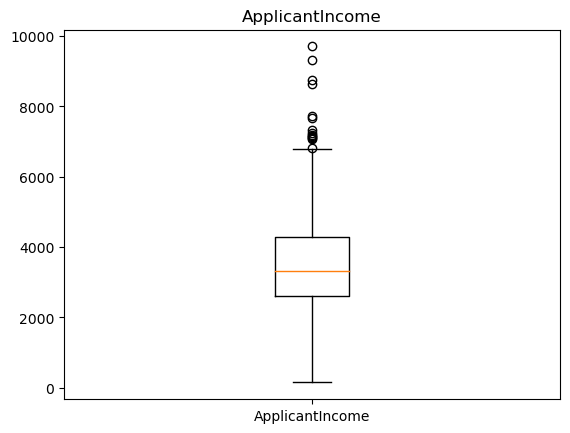

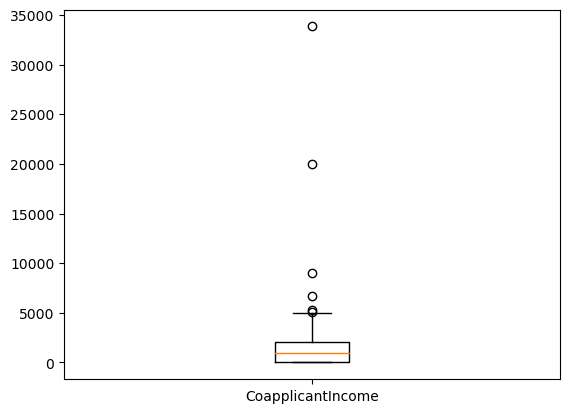

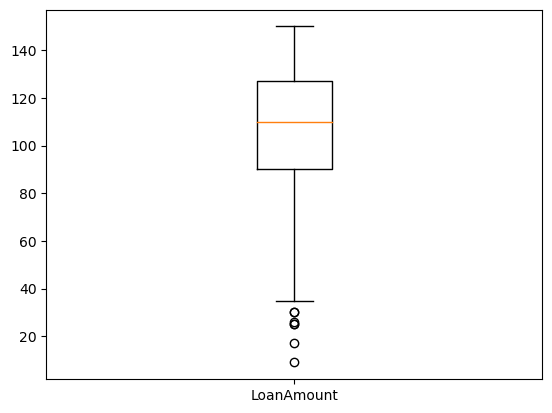

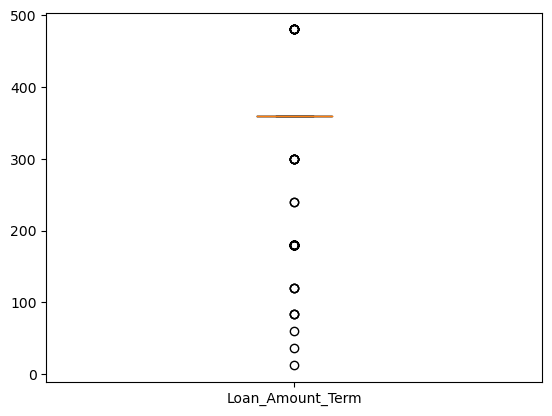

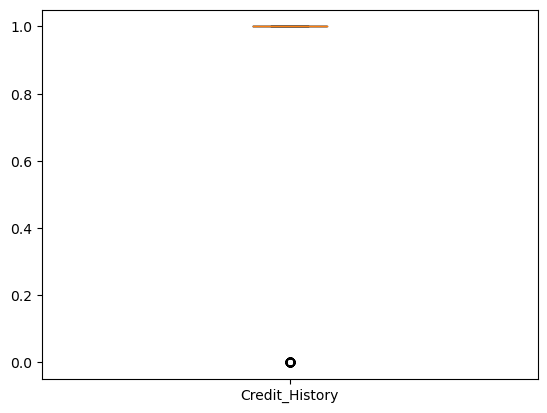

In [23]:
fig, axs = plt.subplots()
for col in num:
    plt.boxplot([df_ohe[col]], labels=[col])
    axs.set_title(col)
    plt.show()

Dużo wartości odstających, jednak nie są one nierealne. Największa rozbieżność w CoapplicantIncome, wartości powyżej 10000 zastąpimy medianą.

In [24]:
median = df_ohe.loc[df_ohe['CoapplicantIncome']<10000, 'CoapplicantIncome'].median()
df_ohe.loc[df_ohe.CoapplicantIncome > 10000, 'CoapplicantIncome'] = np.nan
df_ohe.fillna(median,inplace=True)

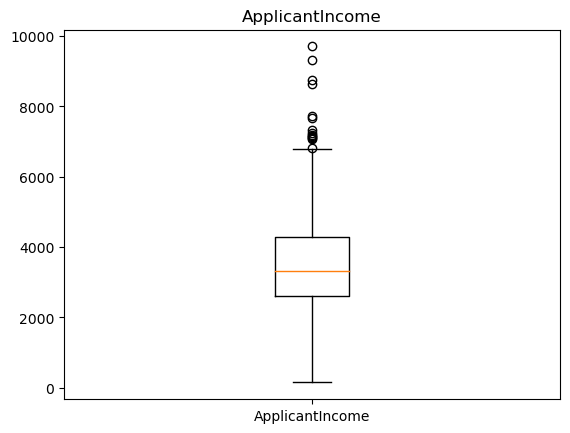

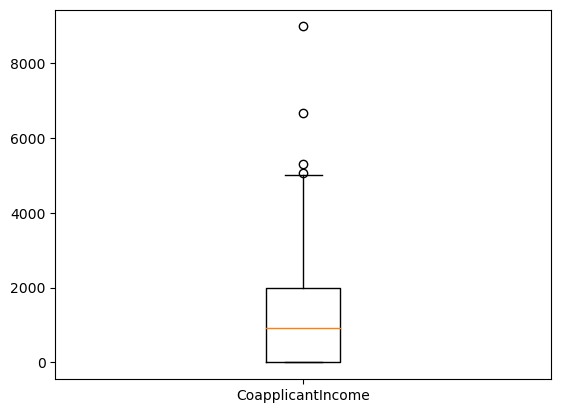

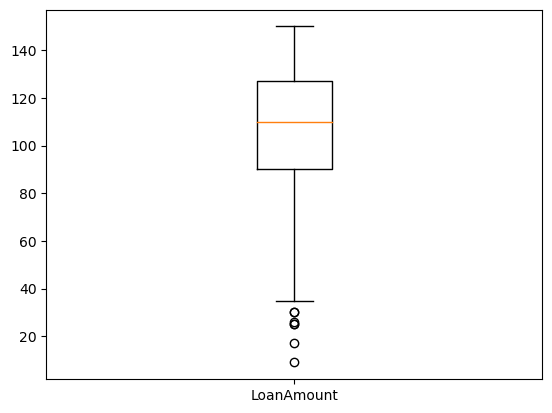

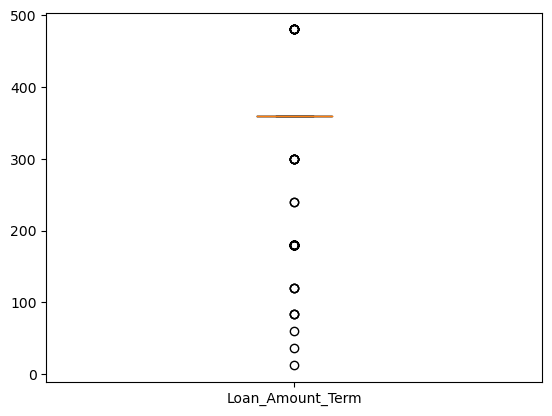

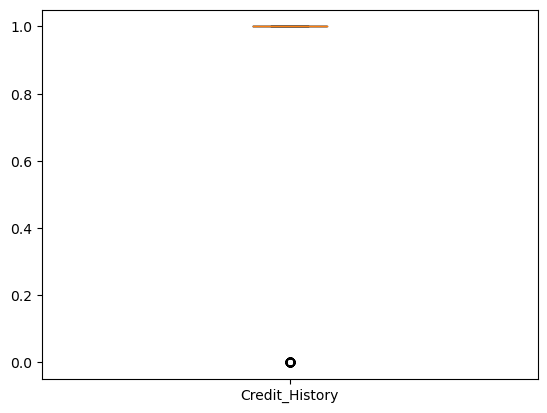

In [25]:
fig, axs = plt.subplots()
for col in num:
    plt.boxplot([df_ohe[col]], labels=[col])
    axs.set_title(col)
    plt.show()

In [26]:
from sklearn.preprocessing import StandardScaler

Skalujemy wartości liczbowe.

In [27]:
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_num)

In [28]:
df_scaled = pd.DataFrame(data=df_scaled, columns=df_num.columns)
df_scaled.head()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
0,0.707469,0.098695,0.812575,0.275147,0.419435
1,-0.408932,-0.546371,-1.376596,0.275147,0.419435
2,-0.703019,0.462294,0.530102,0.275147,0.419435
3,1.706799,-0.546371,1.271595,0.275147,0.419435
4,-0.879330,0.102118,-0.352629,0.275147,0.419435


In [29]:
for col in num:
    df_ohe[col] = df_scaled[col]

In [30]:
df_ohe.head()

,Dependents,Education,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Loan_Status,Gender_Female,Gender_Male,Married_No,Married_Yes,Self_Employed_No,Self_Employed_Yes,Property_Area_Rural,Property_Area_Semiurban,Property_Area_Urban
0,1.0,1.0,0.707469,0.098695,0.812575,0.275147,0.419435,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0
1,0.0,1.0,-0.408932,-0.546371,-1.376596,0.275147,0.419435,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
2,0.0,0.0,-0.703019,0.462294,0.530102,0.275147,0.419435,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0
3,0.0,1.0,1.706799,-0.546371,1.271595,0.275147,0.419435,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
4,0.0,0.0,-0.879330,0.102118,-0.352629,0.275147,0.419435,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0


Dzielimy na zbiory treningowe i testowe

In [31]:
from sklearn.model_selection import train_test_split
train_data, test_data = train_test_split(df_ohe, test_size=0.3, random_state=10)
y_train = train_data.Loan_Status
X_train = train_data.drop("Loan_Status", axis=1)
y_test = test_data.Loan_Status
X_test = test_data.drop("Loan_Status", axis=1)

In [32]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn import svm
from pprint import pprint

Budujemy funkcję do porównywania skuteczności modelu na zbiorze testowym i treningowym

In [33]:
def scorer(model):
    print("Predykcje na zbiorze testowym:")
    pred_test = model.predict(X_test)
    print(confusion_matrix(y_test, pred_test, labels=[0,1]), "\nAccuracy:",accuracy_score(y_test, pred_test),"\nF1:", f1_score(y_test, pred_test))
    print("Predykcje na zbiorze treningowym:")
    pred_train = model.predict(X_train)
    print(confusion_matrix(y_train, pred_train, labels=[0,1]), "\nAccuracy:",accuracy_score(y_train, pred_train),"\nF1:", f1_score(y_train, pred_train))

In [34]:
rfc = RandomForestClassifier(random_state=10)
rfc.fit(X_train, y_train)

RandomForestClassifier(random_state=10)

In [35]:
scorer(rfc)

Predykcje na zbiorze testowym:
[[18 16]
 [ 2 79]] 
Accuracy: 0.8434782608695652 
F1: 0.8977272727272727
Predykcje na zbiorze treningowym:
[[ 76   0]
 [  0 190]] 
Accuracy: 1.0 
F1: 1.0


W pierwszej wersji mamy dobre wyniki dla lasu losowego, jednak widzimy całkowity overfitting na zbiorze testowym - będzie trzeba lepiej dobrać hiperparametry.

In [36]:
print('Parametry:\n')
pprint(rfc.get_params())

Parametry:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 10,
 'verbose': 0,
 'warm_start': False}


In [37]:
param_grid = {
    'bootstrap': [True],
    'max_depth': [2, 3, 4, 5, 6],
    'max_features': [2, 3, 4],
    'min_samples_leaf': [1, 3, 5],
    'min_samples_split': [2, 6, 10],
    'n_estimators': [5, 10, 15]
}
eval = ["accuracy", "f1"]

In [38]:
grid_search = GridSearchCV(estimator = rfc, param_grid = param_grid, 
                          cv = 3, scoring=eval, refit="accuracy")

In [39]:
grid_search.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=10),
             param_grid={'bootstrap': [True], 'max_depth': [2, 3, 4, 5, 6],
                         'max_features': [2, 3, 4],
                         'min_samples_leaf': [1, 3, 5],
                         'min_samples_split': [2, 6, 10],
                         'n_estimators': [5, 10, 15]},
             refit='accuracy', scoring=['accuracy', 'f1'])

In [40]:
print(grid_search.best_estimator_)
print(grid_search.best_params_)
print(grid_search.best_score_)

RandomForestClassifier(max_depth=5, max_features=4, min_samples_leaf=3,
                       n_estimators=10, random_state=10)
{'bootstrap': True, 'max_depth': 5, 'max_features': 4, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 10}
0.8533367381681988


In [41]:
rfc = RandomForestClassifier(max_depth=5, max_features=4, min_samples_leaf=3,
                       n_estimators=10, random_state=10)
rfc.fit(X_train, y_train)

RandomForestClassifier(max_depth=5, max_features=4, min_samples_leaf=3,
                       n_estimators=10, random_state=10)

In [42]:
scorer(rfc)

Predykcje na zbiorze testowym:
[[16 18]
 [ 2 79]] 
Accuracy: 0.8260869565217391 
F1: 0.8876404494382022
Predykcje na zbiorze treningowym:
[[ 47  29]
 [  5 185]] 
Accuracy: 0.8721804511278195 
F1: 0.9158415841584159


Możemy sprawdzić, jakie cechy model uznał za najważniejsze w dokonywaniu predykcji:

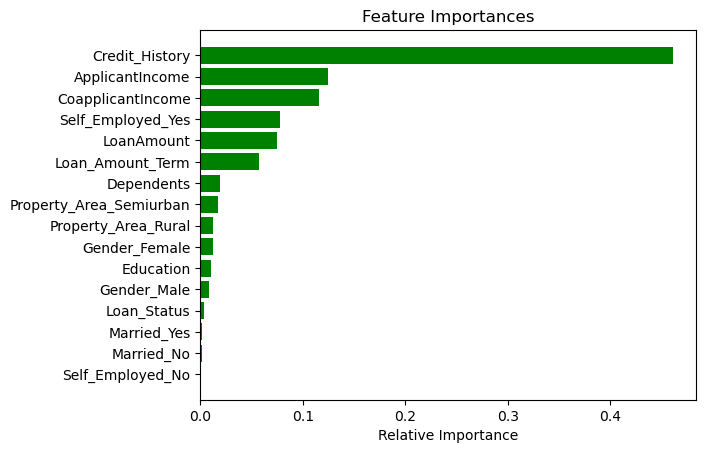

In [80]:
importances = rfc.feature_importances_
indices = np.argsort(importances)
features = df_ohe.columns
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='g', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

Najistotniejszą cechą dla klasyfikatora była wcześniejsza historia kredytowa, której istotność była niemal tak duża, jak wszystkich pozostałych cech razem wziętych.

Następnie sprawdzimy kolejny klasyfikator:

In [43]:
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)

KNeighborsClassifier()

In [44]:
scorer(knn)

Predykcje na zbiorze testowym:
[[15 19]
 [ 2 79]] 
Accuracy: 0.8173913043478261 
F1: 0.88268156424581
Predykcje na zbiorze treningowym:
[[ 48  28]
 [  3 187]] 
Accuracy: 0.8834586466165414 
F1: 0.9234567901234568


Sprawdzimy wyniki dla różnej wartości parametru n_neighbors.

In [45]:
from sklearn import metrics
mean_f1 = np.zeros(20)
mean_acc = np.zeros(20)
for i in range(1,21):
    knn = KNeighborsClassifier(n_neighbors = i).fit(X_train,y_train)
    y_pred= knn.predict(X_test)
    mean_f1[i-1] = metrics.f1_score(y_test, y_pred)
    mean_acc[i-1] = metrics.accuracy_score(y_test, y_pred)

print(pd.DataFrame(mean_f1, mean_acc))

                 0
0.765217  0.838323
0.739130  0.805195
0.826087  0.887640
0.826087  0.885057
0.817391  0.882682
0.826087  0.887640
0.834783  0.895028
0.834783  0.895028
0.834783  0.895028
0.834783  0.895028
0.834783  0.895028
0.834783  0.895028
0.834783  0.895028
0.834783  0.895028
0.834783  0.895028
0.834783  0.895028
0.834783  0.895028
0.834783  0.895028
0.834783  0.895028
0.834783  0.895028


Najlepsze wyniki dla 7+ sąsiadów

In [74]:
knn = KNeighborsClassifier(n_neighbors=7)
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=7)

In [75]:
scorer(knn)

Predykcje na zbiorze testowym:
[[15 19]
 [ 0 81]] 
Accuracy: 0.8347826086956521 
F1: 0.8950276243093923
Predykcje na zbiorze treningowym:
[[ 44  32]
 [  5 185]] 
Accuracy: 0.8609022556390977 
F1: 0.9090909090909092


Sprawdzamy kolejny model:

In [48]:
svm_model = svm.SVC(class_weight='balanced', max_iter=10000)
svm_model.get_params()

{'C': 1.0,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': 'balanced',
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'scale',
 'kernel': 'rbf',
 'max_iter': 10000,
 'probability': False,
 'random_state': None,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

In [49]:
search_grid = [
   {'C': [0.1, 0.5, 1, 5, 10, 20, 50, 100], "class_weight": ['balanced', None], 'kernel': ['linear', 'rbf', 'poly']}]
search_func = GridSearchCV(estimator=svm_model,
                           param_grid=search_grid,
                           scoring=eval,
                           refit='accuracy',
                           cv=5)

In [50]:
search_func.fit(X_train, y_train)

C:\Users\pozyt\anaconda3\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\pozyt\anaconda3\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\pozyt\anaconda3\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\pozyt\anaconda3\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\pozyt\anaconda3\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_it

GridSearchCV(cv=5, estimator=SVC(class_weight='balanced', max_iter=10000),
             param_grid=[{'C': [0.1, 0.5, 1, 5, 10, 20, 50, 100],
                          'class_weight': ['balanced', None],
                          'kernel': ['linear', 'rbf', 'poly']}],
             refit='accuracy', scoring=['accuracy', 'f1'])

In [51]:
print(search_func.best_estimator_)
print(search_func.best_params_)
print(search_func.best_score_)

SVC(C=0.5, class_weight='balanced', kernel='poly', max_iter=10000)
{'C': 0.5, 'class_weight': 'balanced', 'kernel': 'poly'}
0.8610761705101329


In [52]:
svm_final = svm.SVC(C=0.5, class_weight='balanced', kernel='poly', max_iter=10000)

In [53]:
svm_final.fit(X_train, y_train)

SVC(C=0.5, class_weight='balanced', kernel='poly', max_iter=10000)

In [54]:
scorer(svm_final)

Predykcje na zbiorze testowym:
[[15 19]
 [ 1 80]] 
Accuracy: 0.8260869565217391 
F1: 0.888888888888889
Predykcje na zbiorze treningowym:
[[ 45  31]
 [  2 188]] 
Accuracy: 0.8759398496240601 
F1: 0.9193154034229828


Jako że wszystkie modele dają prawie identyczne wyniki na zbiorze testowym, a do tego słabo przewidują odmowy udzielenia kredytu, spróbujemy użyć narzędzia SMOTE do zbalansowania klas

In [55]:
from imblearn.over_sampling import SMOTE
from collections import Counter
X_resampled, y_resampled = SMOTE().fit_resample(X_train, y_train)
print(sorted(Counter(y_resampled).items()))

[(0.0, 190), (1.0, 190)]


In [56]:
def scorer2(model):
    print("Predykcje na zbiorze testowym:")
    pred_test = model.predict(X_test)
    print(confusion_matrix(y_test, pred_test, labels=[0,1]), "\nAccuracy:",accuracy_score(y_test, pred_test),"\nF1:", f1_score(y_test, pred_test))
    print("Predykcje na zbiorze treningowym:")
    pred_train = model.predict(X_resampled)
    print(confusion_matrix(y_resampled, pred_train, labels=[0,1]), "\nAccuracy:",accuracy_score(y_resampled, pred_train),"\nF1:", f1_score(y_resampled, pred_train))

In [57]:
rfc2 = RandomForestClassifier(random_state=10)
rfc2.fit(X_resampled, y_resampled)

RandomForestClassifier(random_state=10)

In [58]:
scorer2(rfc2)

Predykcje na zbiorze testowym:
[[19 15]
 [ 4 77]] 
Accuracy: 0.8347826086956521 
F1: 0.8901734104046243
Predykcje na zbiorze treningowym:
[[190   0]
 [  0 190]] 
Accuracy: 1.0 
F1: 1.0


In [59]:
grid_search = GridSearchCV(estimator = rfc2, param_grid = param_grid, 
                          cv = 3, scoring=eval, refit="accuracy")

In [60]:
grid_search.fit(X_resampled, y_resampled)

GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=10),
             param_grid={'bootstrap': [True], 'max_depth': [2, 3, 4, 5, 6],
                         'max_features': [2, 3, 4],
                         'min_samples_leaf': [1, 3, 5],
                         'min_samples_split': [2, 6, 10],
                         'n_estimators': [5, 10, 15]},
             refit='accuracy', scoring=['accuracy', 'f1'])

In [61]:
print(grid_search.best_estimator_)
print(grid_search.best_params_)
print(grid_search.best_score_)

RandomForestClassifier(max_depth=5, max_features=4, min_samples_leaf=3,
                       min_samples_split=10, n_estimators=10, random_state=10)
{'bootstrap': True, 'max_depth': 5, 'max_features': 4, 'min_samples_leaf': 3, 'min_samples_split': 10, 'n_estimators': 10}
0.8422072240969879


In [62]:
rfc2 = RandomForestClassifier(max_depth=5, max_features=4, min_samples_leaf=3,
                       min_samples_split=10, n_estimators=10, random_state=10)
rfc2.fit(X_resampled, y_resampled)

RandomForestClassifier(max_depth=5, max_features=4, min_samples_leaf=3,
                       min_samples_split=10, n_estimators=10, random_state=10)

In [63]:
scorer2(rfc2)

Predykcje na zbiorze testowym:
[[16 18]
 [ 9 72]] 
Accuracy: 0.7652173913043478 
F1: 0.8421052631578948
Predykcje na zbiorze treningowym:
[[160  30]
 [ 18 172]] 
Accuracy: 0.8736842105263158 
F1: 0.8775510204081632


In [64]:
knn2 = KNeighborsClassifier()
knn2.fit(X_resampled, y_resampled)

KNeighborsClassifier()

In [65]:
scorer2(knn2)

Predykcje na zbiorze testowym:
[[20 14]
 [19 62]] 
Accuracy: 0.7130434782608696 
F1: 0.7898089171974522
Predykcje na zbiorze treningowym:
[[175  15]
 [ 24 166]] 
Accuracy: 0.8973684210526316 
F1: 0.8948787061994609


In [66]:
from sklearn import metrics
mean_f1 = np.zeros(20)
mean_acc = np.zeros(20)
for i in range(1,21):
    knn = KNeighborsClassifier(n_neighbors = i).fit(X_resampled,y_resampled)
    y_pred= knn.predict(X_test)
    mean_f1[i-1] = metrics.f1_score(y_test, y_pred)
    mean_acc[i-1] = metrics.accuracy_score(y_test, y_pred)

print(pd.DataFrame(mean_f1, mean_acc))

                 0
0.721739  0.802469
0.704348  0.773333
0.756522  0.822785
0.721739  0.789474
0.713043  0.789809
0.669565  0.746667
0.721739  0.794872
0.686957  0.763158
0.791304  0.853659
0.730435  0.802548
0.791304  0.857143
0.773913  0.841463
0.800000  0.863905
0.765217  0.834356
0.800000  0.865497
0.782609  0.848485
0.817391  0.878613
0.791304  0.858824
0.800000  0.867052
0.765217  0.840237


In [67]:
knn2 = KNeighborsClassifier(n_neighbors=17)
knn2.fit(X_resampled, y_resampled)

KNeighborsClassifier(n_neighbors=17)

In [68]:
scorer2(knn2)

Predykcje na zbiorze testowym:
[[18 16]
 [ 5 76]] 
Accuracy: 0.8173913043478261 
F1: 0.8786127167630059
Predykcje na zbiorze treningowym:
[[135  55]
 [ 21 169]] 
Accuracy: 0.8 
F1: 0.8164251207729468


In [69]:
svm_model2 = svm.SVC(class_weight='balanced', max_iter=10000)
search_grid = [
   {'C': [0.1, 0.3, 0.5, 1, 2, 5, 7, 10, 15], "class_weight": ['balanced', None], 'kernel': ['linear', 'rbf', 'poly']}]
search_func = GridSearchCV(estimator=svm_model2,
                           param_grid=search_grid,
                           scoring=eval,
                           refit='accuracy',
                           cv=5)

In [70]:
search_func.fit(X_resampled, y_resampled)

C:\Users\pozyt\anaconda3\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\pozyt\anaconda3\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\pozyt\anaconda3\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\pozyt\anaconda3\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\pozyt\anaconda3\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_it

GridSearchCV(cv=5, estimator=SVC(class_weight='balanced', max_iter=10000),
             param_grid=[{'C': [0.1, 0.3, 0.5, 1, 2, 5, 7, 10, 15],
                          'class_weight': ['balanced', None],
                          'kernel': ['linear', 'rbf', 'poly']}],
             refit='accuracy', scoring=['accuracy', 'f1'])

In [71]:
print(search_func.best_estimator_)
print(search_func.best_params_)
print(search_func.best_score_)

SVC(C=7, class_weight='balanced', kernel='poly', max_iter=10000)
{'C': 7, 'class_weight': 'balanced', 'kernel': 'poly'}
0.8368421052631578


In [72]:
svm_final2 = svm.SVC(C=7, class_weight='balanced', kernel='poly', max_iter=10000)
svm_final2.fit(X_resampled, y_resampled)
scorer2(svm_final2)

Predykcje na zbiorze testowym:
[[19 15]
 [11 70]] 
Accuracy: 0.7739130434782608 
F1: 0.8433734939759034
Predykcje na zbiorze treningowym:
[[168  22]
 [ 10 180]] 
Accuracy: 0.9157894736842105 
F1: 0.9183673469387755


Różnice między modelami są niewielkie, jednak najlepszy wynik uzyskał model knn dla 7 sąsiadów bez zastosowania SMOTE'a.

In [76]:
final_model = knn
scorer(final_model)

Predykcje na zbiorze testowym:
[[15 19]
 [ 0 81]] 
Accuracy: 0.8347826086956521 
F1: 0.8950276243093923
Predykcje na zbiorze treningowym:
[[ 44  32]
 [  5 185]] 
Accuracy: 0.8609022556390977 
F1: 0.9090909090909092


Największym ograniczeniem tego zbioru danych jest niewielka liczba rekordów, co utrudniło stworzenie uogólnionego modelu, a dodatkowo zmniejszyło różnice między modelami i ograniczyło skuteczność tuningu hiperparametrów. 